# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_test.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
num_recount2_experiments = params['num_recount2_experiments']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_data_file = params['normalized_compendium_data_file']
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

In [4]:
# Check if analysis output directory exist otherwise create
if not os.path.exists(local_dir):
    os.makedirs(local_dir, exist_ok=True)

In [5]:
# Read data
template_data = pd.read_table(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

print(template_data.shape)
assert(template_data.shape == (24, 17787))
template_data.head()

(24, 17787)


,RNF114,CCDC159,FGG,KCNJ8,DNMT3A,RAD51AP1,KLC4,SIPA1L3,WTAP,JMJD6,...,RAD51D,MMP7,CYP1B1,USP48,NEIL1,LINC01580,NGFR,MFGE8,EIF4E,ZBED5
SRR493937,16.59510,6.39434,0.55957,4.44032,2.50320,0.47352,3.48720,6.21631,15.73463,6.17810,...,1.06188,27.16024,8.73417,4.37320,8.90229,0.00000,2.11732,14.27639,1.15153,2.49812
SRR493938,16.90262,6.19190,0.52505,4.85851,2.40457,0.60641,3.76242,6.04166,14.79566,5.97007,...,1.03761,26.65351,8.97799,4.26366,8.79358,0.00000,2.26755,14.68131,1.08032,2.49682
SRR493939,20.32684,13.25715,3.84222,3.94703,3.99956,1.25835,9.86830,11.98168,11.81426,3.91236,...,1.63649,102.48989,5.96091,10.14924,10.95503,0.00425,4.68624,10.43344,0.93214,5.36385
SRR493940,20.31187,12.59064,4.23856,4.39091,3.99899,1.21753,10.40772,11.99559,11.56296,3.99684,...,1.54549,103.42921,5.97534,9.86503,10.74380,0.00000,4.73489,10.39856,1.08803,5.42666
SRR493941,13.81784,7.03412,0.70396,12.98511,3.56412,0.29325,6.30797,8.13148,8.01858,2.96965,...,1.36525,2.59142,2.86708,4.54700,11.89894,0.00000,0.36175,16.84730,0.99239,4.08062


### Normalize compendium 

In [6]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(91, 17787)


,SLC5A8,SGO1,LINC01095,SLC47A1,TMEM98,CASS4,COX4I2,RABIF,IL6,HAAO,...,PAK6,TSHZ3,RINT1,MTRF1L,NAA25,KLK9,STRA6,WDR61,TINAG,CYP11B1
SRR493816,0.000,0.428,0.015,0.445,3.051,0.082,0.012,7.573,0.05,0.111,...,5.902,0.126,3.446,2.138,1.524,6.616,0.293,3.212,0.000,0.004
SRR493817,0.002,0.309,0.000,0.967,1.018,0.071,0.082,5.591,0.00,0.125,...,6.455,0.136,2.942,1.387,1.305,8.621,0.203,1.998,0.000,0.005
SRR547975,0.000,6.772,0.000,40.699,0.007,0.022,0.000,7.677,0.00,0.007,...,0.053,0.000,7.338,6.945,6.138,0.000,0.005,4.054,0.000,0.000
SRR547973,0.000,4.447,0.000,0.000,7.049,0.139,0.000,5.949,0.00,0.779,...,2.986,0.000,12.658,3.166,5.856,0.000,0.025,2.106,0.759,0.000
SRR547968,0.000,3.000,0.008,0.015,12.743,0.038,0.000,7.660,0.00,0.263,...,0.036,0.263,16.150,3.970,6.036,0.000,0.000,5.110,8.169,0.000


In [7]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(91, 17787)


,SLC5A8,SGO1,LINC01095,SLC47A1,TMEM98,CASS4,COX4I2,RABIF,IL6,HAAO,...,PAK6,TSHZ3,RINT1,MTRF1L,NAA25,KLK9,STRA6,WDR61,TINAG,CYP11B1
SRR493816,0.000000,0.041825,0.234375,0.010934,0.142099,0.006382,0.000415,0.568373,0.000661,0.009244,...,0.657531,0.019721,0.162200,0.150733,0.167218,0.767428,0.020465,0.463225,0.000000,0.081633
SRR493817,0.001277,0.030196,0.000000,0.023760,0.047413,0.005526,0.002836,0.419619,0.000000,0.010410,...,0.719140,0.021287,0.138381,0.097786,0.143078,1.000000,0.014179,0.288145,0.000000,0.102041
SRR547975,0.000000,0.661781,0.000000,1.000000,0.000326,0.001712,0.000000,0.576178,0.000000,0.000583,...,0.005905,0.000000,0.346141,0.489636,0.675816,0.000000,0.000349,0.584655,0.000000,0.000000
SRR547973,0.000000,0.434574,0.000000,0.000000,0.328303,0.010819,0.000000,0.446488,0.000000,0.064873,...,0.332665,0.000000,0.597571,0.223209,0.644731,0.000000,0.001746,0.303721,0.092912,0.000000
SRR547968,0.000000,0.293169,0.125000,0.000369,0.593498,0.002958,0.000000,0.574902,0.000000,0.021902,...,0.004011,0.041165,0.762607,0.279893,0.664572,0.000000,0.000000,0.736948,1.000000,0.000000


In [8]:
# Save data
original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

# Save scaler transform
outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [9]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

creating new directory: /home/alexandra/Documents/Repos/generic-expression-patterns/tests/models
creating new directory: /home/alexandra/Documents/Repos/generic-expression-patterns/tests/logs
creating new directory: /home/alexandra/Documents/Repos/generic-expression-patterns/tests/models/NN_2500_30
creating new directory: /home/alexandra/Documents/Repos/generic-expression-patterns/tests/logs/NN_2500_30


input dataset contains 91 samples and 17787 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 82 samples, validate on 9 samples
Epoch 1/5
82/82 [==============================] - 22s 268ms/step - loss: 9443.7777 - val_loss: 55607.1458
Epoch 2/5
82/82 [==============================] - 21s 261ms/step - loss: 8469.7343 - val_loss: 15483.5392
Epoch 3/5
82/82 [==============================] - 21s 262ms/step - loss: 8218.2462 - val_loss: 15048.3982
Epoch 4/5
82/82 [==============================] - 21s 262ms/step - loss: 8222.2481 - val_loss: 15608.5088
Epoch 5/5
82/82 [==============================] - 22s 263ms/step - loss: 8158.1134 - val_loss: 11061.6910


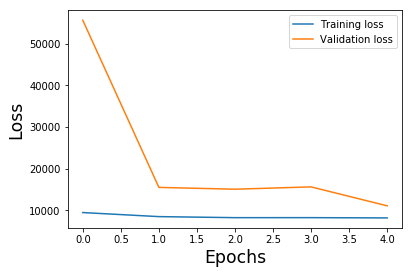

In [10]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

In [11]:
# Test reproducibility
template_path = "data/test_vae_logs.tsv"
output_path = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert np.all(np.isclose(
    pd.read_csv(output_path, sep="\t").values,
    pd.read_csv(template_path, sep="\t").values
    ))